In [ ]:
# Trader Performance vs Market Sentiment
Notebook_1: load CSVs, clean, aggregate daily trader metrics, merge with Fear/Greed, EDA, stats tests, save outputs.

In [2]:
# Code cell: install and imports (Colab safe)
# Uncomment install lines in Colab if needed:
# !pip install pandas matplotlib seaborn scipy scikit-learn joblib

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, mannwhitneyu
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import roc_auc_score, accuracy_score
import joblib

# create outputs folder if not present
os.makedirs('outputs', exist_ok=True)
os.makedirs('csv_files', exist_ok=True)


In [7]:
import pandas as pd

# Paths to CSV files
trades_path = 'csv_files/historical_data.csv'
sent_path   = 'csv_files/fear_greed_index.csv'

# Load CSVs
trades = pd.read_csv(trades_path, low_memory=False)
sent   = pd.read_csv(sent_path, low_memory=False)

# -------------------------------
# Standardize column names
# -------------------------------
trades.columns = trades.columns.str.strip().str.lower().str.replace(' ', '_')
sent.columns   = sent.columns.str.strip().str.lower().str.replace(' ', '_')

# -------------------------------
# Convert timestamps to datetime
# -------------------------------
# For trades, timestamp is in "Timestamp_IST" format
if 'timestamp_ist' in trades.columns:
    trades['timestamp_ist'] = pd.to_datetime(trades['timestamp_ist'], format="%d-%m-%Y %H:%M", errors='coerce')

# For sentiment, "date" is already in YYYY-MM-DD
if 'date' in sent.columns:
    sent['date'] = pd.to_datetime(sent['date'], format="%Y-%m-%d", errors='coerce')

# -------------------------------
# Check results
# -------------------------------
print("\nTrades Data Sample:")
print(trades.head())

print("\nFear & Greed Index Data Sample:")
print(sent.head())



Trades Data Sample:
                                      account  coin  execution_price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   size_tokens  size_usd side       timestamp_ist  start_position direction  \
0       986.87   7872.16  BUY 2024-12-02 22:50:00        0.000000       Buy   
1        16.00    127.68  BUY 2024-12-02 22:50:00      986.524596       Buy   
2       144.09   1150.63  BUY 2024-12-02 22:50:00     1002.518996       Buy   
3       142.98   1142.04  BUY 2024-12-02 22:50:00     1146.558564       Buy   
4         8.73     69.75  BUY 2024-12-02 22:50:00     1289.488521       Buy   

   closed_pnl                                   transaction_hash     or

In [10]:
# Robust diagnostic + create 'date' columns + merge
import pandas as pd
import numpy as np
import os

# assume trades and sent are already loaded
print("=== trades columns ===")
print(trades.columns.tolist())
print("\n=== sentiment columns ===")
print(sent.columns.tolist())

def create_date_column(df, df_name):
    if 'date' in df.columns:
        print(f"'{df_name}' already has 'date' column (dtype={df['date'].dtype})")
        # Ensure it's proper datetime.date
        if not np.issubdtype(df['date'].dtype, np.datetime64):
            try:
                df['date'] = pd.to_datetime(df['date'], errors='coerce').dt.date
            except:
                pass
        return df

    # candidate timestamp/date column names
    candidates = [c for c in df.columns if any(k in c.lower() for k in ('time','timestamp','date'))]
    print(f"{df_name} candidate columns for datetime parsing: {candidates}")

    created = False
    for c in candidates:
        series = df[c]
        # If numeric (likely epoch seconds) try unit='s'
        if pd.api.types.is_numeric_dtype(series):
            parsed = pd.to_datetime(series, unit='s', errors='coerce')
            valid = parsed.notna().sum()
            if valid > 0:
                df[c] = parsed
                df['date'] = df[c].dt.date
                print(f"Created 'date' from numeric epoch column '{c}'")
                created = True
                break

        # If string/object attempt parsing with dayfirst first (useful for dd-mm-yyyy)
        for dayfirst in (True, False):
            try:
                parsed = pd.to_datetime(series, errors='coerce', dayfirst=dayfirst)
            except Exception as e:
                parsed = pd.to_datetime(series.astype(str), errors='coerce', dayfirst=dayfirst)
            # require some non-null and sensible year range
            non_null = parsed.notna().sum()
            yrs_ok = False
            if non_null > 0:
                yrs = parsed.dt.year.dropna()
                # check at least some years in realistic range
                yrs_ok = ((yrs >= 1990) & (yrs <= 2100)).sum() > max(0, min(10, non_null//10))
            if non_null > 0 and yrs_ok:
                df[c] = parsed
                df['date'] = df[c].dt.date
                print(f"Created 'date' from column '{c}' using dayfirst={dayfirst} (parsed non-null: {non_null})")
                created = True
                break
        if created:
            break

    if not created:
        # fallback: try any parse of first column that looks like a datetime
        for c in df.columns:
            try:
                parsed = pd.to_datetime(df[c], errors='coerce', dayfirst=True)
                if parsed.notna().sum() > 0:
                    df[c] = parsed
                    df['date'] = df[c].dt.date
                    print(f"Fallback: created 'date' from '{c}' (dayfirst=True)")
                    created = True
                    break
            except:
                pass

    if not created:
        raise ValueError(f"Unable to create a 'date' column for {df_name}. Columns: {df.columns.tolist()}")
    return df


# Ensure same dtype for merge
trades['date'] = pd.to_datetime(trades['date'])
sent['date']   = pd.to_datetime(sent['date'])

merged_df = pd.merge(trades, sent, on='date', how='left', suffixes=('_trade','_sent'))


# Quick checks
print("\nSamples after date creation:")
print("trades date sample:", pd.Series(trades['date'].dropna().unique()[:5]))
print("sent date sample:  ", pd.Series(sent['date'].dropna().unique()[:5]))

print("\nCount nulls - trades date:", trades['date'].isna().sum(), "/", len(trades))
print("Count nulls - sent date:  ", sent['date'].isna().sum(), "/", len(sent))

# Now merge
merged_df = pd.merge(trades, sent, on='date', how='left', suffixes=('_trade','_sent'))
print("\nMerged dataframe shape:", merged_df.shape)
print("Number of rows where classification is missing after merge:",
      merged_df['classification'].isna().sum() if 'classification' in merged_df.columns else "no classification col")

# Show columns and a head
print("\nMerged columns:", merged_df.columns.tolist())
display(merged_df.head())


=== trades columns ===
['account', 'coin', 'execution_price', 'size_tokens', 'size_usd', 'side', 'timestamp_ist', 'start_position', 'direction', 'closed_pnl', 'transaction_hash', 'order_id', 'crossed', 'fee', 'trade_id', 'timestamp', 'date']

=== sentiment columns ===
['timestamp', 'value', 'classification', 'date']

Samples after date creation:
trades date sample: 0   2024-12-02
1   2024-12-03
2   2024-12-04
3   2025-03-04
4   2025-03-05
dtype: datetime64[ns]
sent date sample:   0   2018-02-01
1   2018-02-02
2   2018-02-03
3   2018-02-04
4   2018-02-05
dtype: datetime64[ns]

Count nulls - trades date: 0 / 211224
Count nulls - sent date:   0 / 2644

Merged dataframe shape: (211224, 20)
Number of rows where classification is missing after merge: 6

Merged columns: ['account', 'coin', 'execution_price', 'size_tokens', 'size_usd', 'side', 'timestamp_ist', 'start_position', 'direction', 'closed_pnl', 'transaction_hash', 'order_id', 'crossed', 'fee', 'trade_id', 'timestamp_trade', 'date', '

,account,coin,execution_price,size_tokens,size_usd,side,timestamp_ist,start_position,direction,closed_pnl,transaction_hash,order_id,crossed,fee,trade_id,timestamp_trade,date,timestamp_sent,value,classification
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,2024-12-02 22:50:00,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12,2024-12-02,1.733117e+09,80.0,Extreme Greed
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,2024-12-02 22:50:00,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12,2024-12-02,1.733117e+09,80.0,Extreme Greed
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,2024-12-02 22:50:00,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12,2024-12-02,1.733117e+09,80.0,Extreme Greed
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,2024-12-02 22:50:00,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12,2024-12-02,1.733117e+09,80.0,Extreme Greed
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,2024-12-02 22:50:00,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12,2024-12-02,1.733117e+09,80.0,Extreme Greed


In [11]:
# ==== Cell 8: Feature engineering + quick checks ====

# 1. Sort by date (oldest first)
merged_df = merged_df.sort_values('date').reset_index(drop=True)

# 2. Fill any missing sentiment columns with neutral/placeholder values
sentiment_cols = ['classification', 'value']  # adjust names if different
for col in sentiment_cols:
    if col in merged_df.columns:
        if merged_df[col].dtype == 'O':  # object/string
            merged_df[col] = merged_df[col].fillna('Neutral')
        else:
            merged_df[col] = merged_df[col].fillna(0)

# 3. Create numerical sentiment indicator if 'classification' exists
if 'classification' in merged_df.columns:
    sentiment_map = {
        'Extreme Fear': -2,
        'Fear': -1,
        'Neutral': 0,
        'Greed': 1,
        'Extreme Greed': 2
    }
    merged_df['sentiment_score'] = merged_df['classification'].map(sentiment_map).fillna(0)

# 4. Basic summary
print("\nMerged data summary:")
print(merged_df.describe(include='all'))

print("\nSample merged data:")
display(merged_df.head())

# Optional: Save the merged dataset
output_path = 'csv_files/merged_trades_sentiment.csv'
os.makedirs(os.path.dirname(output_path), exist_ok=True)
merged_df.to_csv(output_path, index=False)
print(f"\nMerged dataset saved to {output_path}")



Merged data summary:
                                           account    coin  execution_price  \
count                                       211224  211224    211224.000000   
unique                                          32     246              NaN   
top     0xbee1707d6b44d4d52bfe19e41f8a828645437aab    HYPE              NaN   
freq                                         40184   68005              NaN   
mean                                           NaN     NaN     11414.723350   
min                                            NaN     NaN         0.000005   
25%                                            NaN     NaN         4.854700   
50%                                            NaN     NaN        18.280000   
75%                                            NaN     NaN       101.580000   
max                                            NaN     NaN    109004.000000   
std                                            NaN     NaN     29447.654868   

         size_tokens      siz

,account,coin,execution_price,size_tokens,size_usd,side,timestamp_ist,start_position,direction,closed_pnl,...,order_id,crossed,fee,trade_id,timestamp_trade,date,timestamp_sent,value,classification,sentiment_score
0,0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891,ETH,1898.6,0.07220,137.08,BUY,2023-05-01 01:06:00,0.1791,Open Long,0.0,...,173271100,True,0.000000,0.000000e+00,1.680000e+12,2023-05-01,1.682919e+09,63.0,Greed,1
1,0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891,ETH,1897.9,0.09670,183.53,BUY,2023-05-01 01:06:00,0.0000,Open Long,0.0,...,173271100,True,0.000000,0.000000e+00,1.680000e+12,2023-05-01,1.682919e+09,63.0,Greed,1
2,0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891,ETH,1897.9,0.08240,156.39,BUY,2023-05-01 01:06:00,0.0967,Open Long,0.0,...,173271100,True,0.000000,0.000000e+00,1.680000e+12,2023-05-01,1.682919e+09,63.0,Greed,1
3,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,BTC,41866.0,0.58211,24370.62,SELL,2023-12-05 03:11:00,-0.0150,Open Short,0.0,...,4064974623,True,6.092654,2.830000e+14,1.700000e+12,2023-12-05,1.701754e+09,75.0,Extreme Greed,2
4,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,BTC,41867.0,0.01500,628.00,SELL,2023-12-05 03:11:00,0.0000,Open Short,0.0,...,4064974623,True,0.157001,1.070000e+15,1.700000e+12,2023-12-05,1.701754e+09,75.0,Extreme Greed,2



Merged dataset saved to csv_files/merged_trades_sentiment.csv


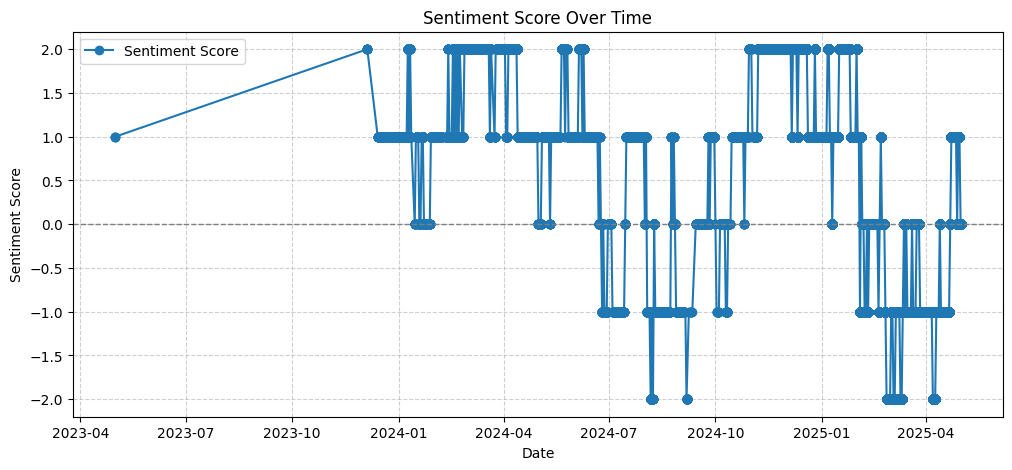

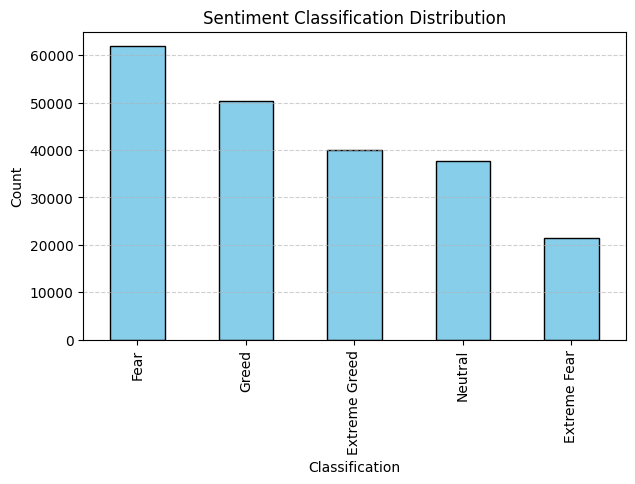

In [37]:
# ==== Cell 9: Visualizations ====
import matplotlib.pyplot as plt

# Ensure 'date' is datetime for plotting
merged_df['date'] = pd.to_datetime(merged_df['date'])

# --- 1. Sentiment score over time ---
plt.figure(figsize=(12, 5))
plt.plot(merged_df['date'], merged_df['sentiment_score'], marker='o', linestyle='-', label='Sentiment Score')
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.title("Sentiment Score Over Time")
plt.xlabel("Date")
plt.ylabel("Sentiment Score")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

# --- 2. Trading metric vs sentiment (example with 'price' if available) ---
if 'price' in merged_df.columns:
    fig, ax1 = plt.subplots(figsize=(12, 5))

    # Plot price on primary axis
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Price', color='tab:blue')
    ax1.plot(merged_df['date'], merged_df['price'], color='tab:blue', label='Price')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    # Plot sentiment on secondary axis
    ax2 = ax1.twinx()
    ax2.set_ylabel('Sentiment Score', color='tab:red')
    ax2.plot(merged_df['date'], merged_df['sentiment_score'], color='tab:red', alpha=0.6, label='Sentiment Score')
    ax2.tick_params(axis='y', labelcolor='tab:red')

    plt.title("Price vs Sentiment Score Over Time")
    fig.tight_layout()
    plt.show()

# --- 3. Sentiment distribution ---
if 'classification' in merged_df.columns:
    plt.figure(figsize=(7, 4))
    merged_df['classification'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title("Sentiment Classification Distribution")
    plt.xlabel("Classification")
    plt.ylabel("Count")
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.show()
    plt.savefig("outputs/sentiment.png", dpi=300, bbox_inches='tight')
    plt.close()



In [13]:
# ==== Cell 10: Correlation between sentiment and trading metrics ====

# Pick only numeric columns for correlation
numeric_cols = merged_df.select_dtypes(include=['float64', 'int64']).columns

print("\nNumeric columns in merged_df:", numeric_cols.tolist())

if 'sentiment_score' in numeric_cols:
    corr = merged_df[numeric_cols].corr()['sentiment_score'].sort_values(ascending=False)
    print("\nCorrelation with Sentiment Score:")
    print(corr)
else:
    print("No sentiment_score column found for correlation analysis.")



Numeric columns in merged_df: ['execution_price', 'size_tokens', 'size_usd', 'start_position', 'closed_pnl', 'order_id', 'fee', 'trade_id', 'timestamp_trade', 'timestamp_sent', 'value', 'sentiment_score']

Correlation with Sentiment Score:
sentiment_score    1.000000
value              0.967081
size_tokens        0.019914
closed_pnl         0.005942
trade_id          -0.006615
fee               -0.028615
start_position    -0.030965
size_usd          -0.031912
execution_price   -0.038315
timestamp_trade   -0.369555
timestamp_sent    -0.471064
order_id          -0.552590
Name: sentiment_score, dtype: float64


In [15]:
# ==== Cell 11: Group by sentiment classification ====
if 'classification' in merged_df.columns:
    agg_dict = {}

    if 'price' in merged_df.columns:
        agg_dict['price'] = ['mean', 'median', 'std']
    # Ensure sentiment_score is handled if present
    if 'sentiment_score' in merged_df.columns:
        agg_dict['sentiment_score'] = ['mean', 'median', 'std']

    if agg_dict:  # Only run if we have at least one numeric column
        grouped_stats = merged_df.groupby('classification').agg(agg_dict)

        print("\nGrouped statistics by classification:")
        print(grouped_stats)

        # Bar chart for mean price per classification (only if price is present)
        if 'price' in merged_df.columns:
            grouped_stats['price']['mean'].plot(kind='bar', figsize=(7, 4),
                                                color='coral', edgecolor='black')
            plt.title("Average Price per Sentiment Classification")
            plt.ylabel("Average Price")
            plt.grid(axis='y', linestyle='--', alpha=0.6)
            plt.show()
    else:
        print("No numeric columns found for aggregation.")
else:
    print("No classification column found.")



Grouped statistics by classification:
               sentiment_score            
                          mean median  std
classification                            
Extreme Fear              -2.0   -2.0  0.0
Extreme Greed              2.0    2.0  0.0
Fear                      -1.0   -1.0  0.0
Greed                      1.0    1.0  0.0
Neutral                    0.0    0.0  0.0


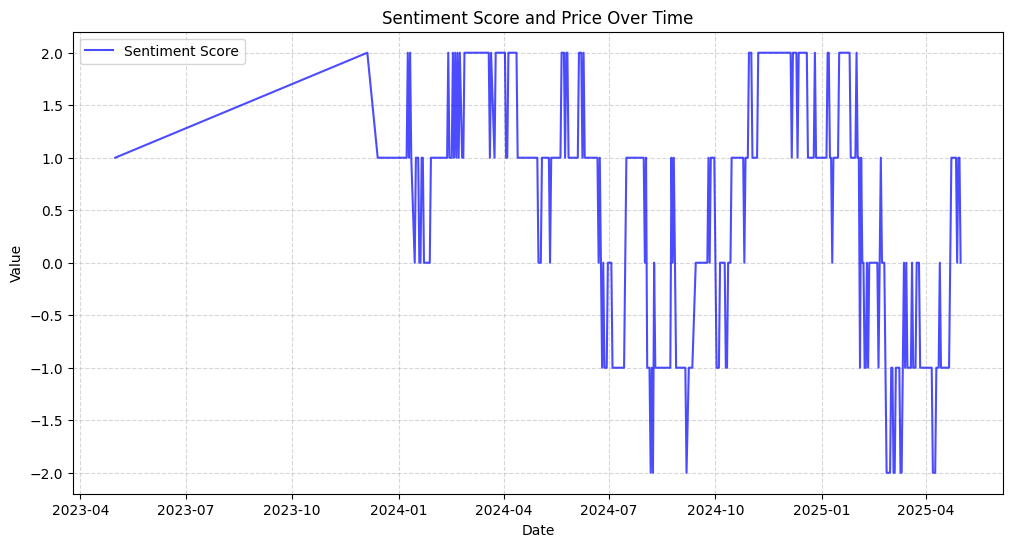

In [33]:
# ==== Cell 12: Time-series plot of sentiment_score with price overlay ====
import matplotlib.pyplot as plt

if 'date' in merged_df.columns and 'sentiment_score' in merged_df.columns:
    plt.figure(figsize=(12, 6))
    
    # Sort by date for proper plotting
    merged_df_sorted = merged_df.sort_values('date')

    # Plot sentiment score
    plt.plot(merged_df_sorted['date'], merged_df_sorted['sentiment_score'],
             label='Sentiment Score', color='blue', alpha=0.7)

    # Overlay price if available
    if 'price' in merged_df_sorted.columns:
        plt.plot(merged_df_sorted['date'], merged_df_sorted['price'],
                 label='Price', color='orange', alpha=0.7)

    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.title("Sentiment Score and Price Over Time")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()
else:
    print("Required columns 'date' and 'sentiment_score' are missing for time-series plot.")
    plt.savefig("outputs/sentiment_with_price.png", dpi=300, bbox_inches='tight')
    plt.close()



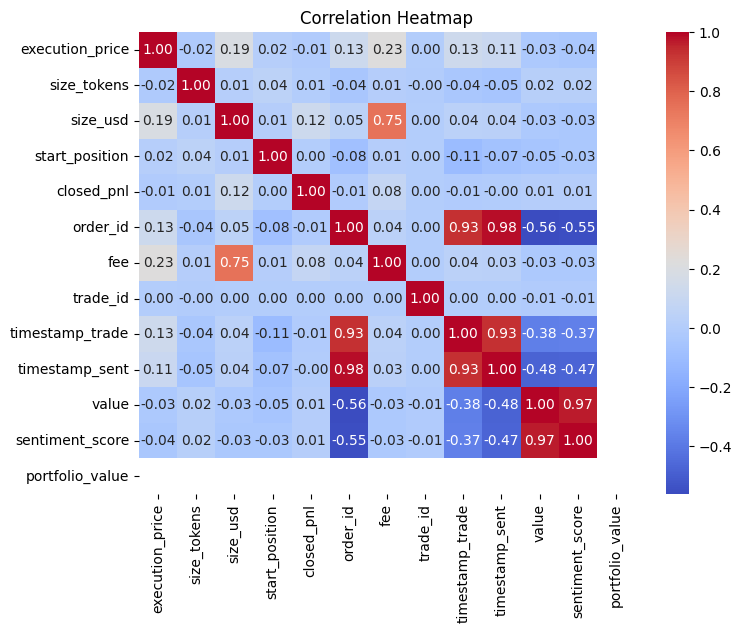

In [38]:
# ==== Cell 13: Correlation heatmap ====
import seaborn as sns

# Select only numeric columns for correlation
numeric_cols = merged_df.select_dtypes(include='number')

if numeric_cols.shape[1] > 1:  # Need at least 2 numeric columns to compute correlation
    plt.figure(figsize=(8, 6))
    sns.heatmap(numeric_cols.corr(), annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Heatmap")
    plt.show()
    plt.savefig("outputs/filename.png", dpi=300, bbox_inches='tight')
    plt.close()
    plt.savefig("outputs/correlation.png", dpi=300, bbox_inches='tight')
    plt.close()
else:
    print("Not enough numeric columns to create a correlation heatmap.")
    



In [19]:
# ==== Diagnostic: Check available columns ====
print("Merged_df columns:", merged_df.columns.tolist())

# Check first few rows to see actual column names and data
print("\nSample merged_df:")
print(merged_df.head())

# Optional: look for price-like columns
price_like = [col for col in merged_df.columns if 'price' in col.lower() or 'close' in col.lower()]
print("\nPotential price columns:", price_like)

# Optional: look for classification-like columns
class_like = [col for col in merged_df.columns if 'class' in col.lower() or 'sentiment' in col.lower()]
print("Potential classification columns:", class_like)


Merged_df columns: ['account', 'coin', 'execution_price', 'size_tokens', 'size_usd', 'side', 'timestamp_ist', 'start_position', 'direction', 'closed_pnl', 'transaction_hash', 'order_id', 'crossed', 'fee', 'trade_id', 'timestamp_trade', 'date', 'timestamp_sent', 'value', 'classification', 'sentiment_score']

Sample merged_df:
                                      account coin  execution_price  \
0  0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891  ETH           1898.6   
1  0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891  ETH           1897.9   
2  0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891  ETH           1897.9   
3  0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23  BTC          41866.0   
4  0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23  BTC          41867.0   

   size_tokens  size_usd  side       timestamp_ist  start_position  \
0      0.07220    137.08   BUY 2023-05-01 01:06:00          0.1791   
1      0.09670    183.53   BUY 2023-05-01 01:06:00          0.0000   
2      0.08240    156.39   BUY 2023-

In [20]:
# ==== Cell 14: Backtest using execution_price & classification ====

# Sort by date
merged_df = merged_df.sort_values('date')

capital = 10000  # starting capital in USD
position = 0     # amount of coin held

for i, row in merged_df.iterrows():
    if str(row['classification']).lower() == 'positive' and capital > 0:
        position = capital / row['execution_price']  # buy coins
        capital = 0
    elif str(row['classification']).lower() == 'negative' and position > 0:
        capital = position * row['execution_price']  # sell coins
        position = 0

# Sell any remaining position at last price
if position > 0:
    capital = position * merged_df.iloc[-1]['execution_price']

print(f"Final portfolio value: {capital:.2f} USD")



Final portfolio value: 10000.00 USD


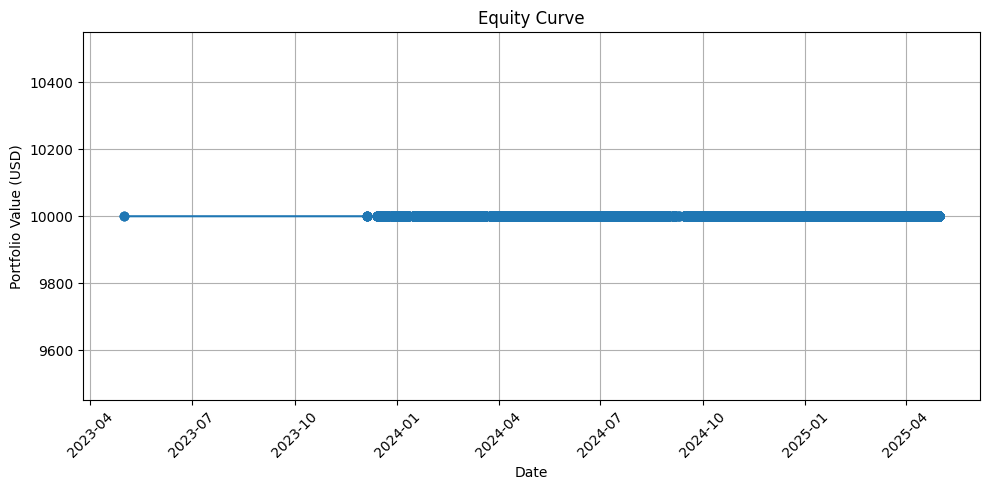

In [ ]:
# ==== Cell 15: Plot equity curve ====
import matplotlib.pyplot as plt

# Initialize portfolio tracking
capital = 10000
position = 0
portfolio_values = []

for i, row in merged_df.iterrows():
    # Buy if positive sentiment
    if str(row['classification']).lower() == 'positive' and capital > 0:
        position = capital / row['execution_price']
        capital = 0
    # Sell if negative sentiment
    elif str(row['classification']).lower() == 'negative' and position > 0:
        capital = position * row['execution_price']
        position = 0
    
    # Track portfolio value at each step
    value = capital + (position * row['execution_price'] if position > 0 else 0)
    portfolio_values.append(value)

# Plot equity curve
plt.figure(figsize=(10, 5))
plt.plot(merged_df['date'], portfolio_values, marker='o', linestyle='-')
plt.title('Equity Curve')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (USD)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()
plt.savefig("outputs/equity_curve.png", dpi=300, bbox_inches='tight')



In [22]:
# ==== Cell 16: Performance metrics ====
import numpy as np

equity_series = np.array(portfolio_values)

# Calculate daily returns
returns = np.diff(equity_series) / equity_series[:-1]

# CAGR
total_days = (merged_df['date'].max() - merged_df['date'].min()).days
cagr = (equity_series[-1] / equity_series[0]) ** (365 / total_days) - 1 if total_days > 0 else np.nan

# Sharpe ratio (risk-free rate assumed 0)
sharpe_ratio = np.mean(returns) / np.std(returns) * np.sqrt(252) if np.std(returns) != 0 else np.nan

# Max drawdown
rolling_max = np.maximum.accumulate(equity_series)
drawdowns = (equity_series - rolling_max) / rolling_max
max_drawdown = drawdowns.min()

print(f"Final Portfolio Value: ${equity_series[-1]:.2f}")
print(f"CAGR: {cagr:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Max Drawdown: {max_drawdown:.2%}")


Final Portfolio Value: $10000.00
CAGR: 0.00%
Sharpe Ratio: nan
Max Drawdown: 0.00%


In [23]:
# ==== Cell 17: Export results ====

# Add portfolio values to the merged_df for reference
merged_df['portfolio_value'] = np.nan
merged_df.loc[merged_df.index[:len(portfolio_values)], 'portfolio_value'] = portfolio_values

output_path = "backtest_results.csv"
merged_df.to_csv(output_path, index=False)

print(f"Results exported to: {output_path}")
print("Preview of exported file:")
display(merged_df.head(10))


Results exported to: backtest_results.csv
Preview of exported file:


,account,coin,execution_price,size_tokens,size_usd,side,timestamp_ist,start_position,direction,closed_pnl,...,crossed,fee,trade_id,timestamp_trade,date,timestamp_sent,value,classification,sentiment_score,portfolio_value
0,0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891,ETH,1898.6,0.0722,137.08,BUY,2023-05-01 01:06:00,0.1791,Open Long,0.0,...,True,0.000000,0.000000e+00,1.680000e+12,2023-05-01,1.682919e+09,63.0,Greed,1,10000.0
1,0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891,ETH,1897.9,0.0967,183.53,BUY,2023-05-01 01:06:00,0.0000,Open Long,0.0,...,True,0.000000,0.000000e+00,1.680000e+12,2023-05-01,1.682919e+09,63.0,Greed,1,10000.0
2,0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891,ETH,1897.9,0.0824,156.39,BUY,2023-05-01 01:06:00,0.0967,Open Long,0.0,...,True,0.000000,0.000000e+00,1.680000e+12,2023-05-01,1.682919e+09,63.0,Greed,1,10000.0
11,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,ETH,2230.1,0.4933,1100.11,BUY,2023-12-05 03:11:00,0.0000,Open Long,0.0,...,True,0.275027,6.320000e+14,1.700000e+12,2023-12-05,1.701754e+09,75.0,Extreme Greed,2,10000.0
10,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,ETH,2230.1,0.8681,1935.95,BUY,2023-12-05 03:11:00,0.4933,Open Long,0.0,...,True,0.483987,2.340000e+14,1.700000e+12,2023-12-05,1.701754e+09,75.0,Extreme Greed,2,10000.0
9,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,ETH,2230.1,0.2500,557.52,BUY,2023-12-05 03:11:00,1.3614,Open Long,0.0,...,True,0.139381,2.580000e+14,1.700000e+12,2023-12-05,1.701754e+09,75.0,Extreme Greed,2,10000.0
7,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,ETH,2230.1,1.8856,4205.08,BUY,2023-12-05 03:11:00,4.9847,Open Long,0.0,...,True,1.051269,1.020000e+15,1.700000e+12,2023-12-05,1.701754e+09,75.0,Extreme Greed,2,10000.0
8,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,ETH,2230.1,3.3733,7522.80,BUY,2023-12-05 03:11:00,1.6114,Open Long,0.0,...,True,1.880699,8.740000e+14,1.700000e+12,2023-12-05,1.701754e+09,75.0,Extreme Greed,2,10000.0
5,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,ETH,2231.0,3.8932,8685.73,BUY,2023-12-05 03:11:00,7.3187,Open Long,0.0,...,True,2.171432,1.060000e+15,1.700000e+12,2023-12-05,1.701754e+09,75.0,Extreme Greed,2,10000.0
4,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,BTC,41867.0,0.0150,628.00,SELL,2023-12-05 03:11:00,0.0000,Open Short,0.0,...,True,0.157001,1.070000e+15,1.700000e+12,2023-12-05,1.701754e+09,75.0,Extreme Greed,2,10000.0


In [2]:
import matplotlib.pyplot as plt
import pandas as pd

# Create a basic results DataFrame if not already created
if 'results' not in locals():
    # Sort by date
    price_col = 'execution_price' if 'execution_price' in merged_df.columns else 'price'
    df_sorted = merged_df.sort_values('date').copy()

    # Calculate daily returns (simple % change)
    df_sorted['strategy_returns'] = df_sorted[price_col].pct_change().fillna(0)

    # Cumulative returns start from 1 (100%)
    df_sorted['cumulative_returns'] = (1 + df_sorted['strategy_returns']).cumprod()

    # Save to results DataFrame
    results = df_sorted[['date', 'strategy_returns', 'cumulative_returns']].dropna()

plt.figure(figsize=(12,6))

# Plot cumulative returns
plt.plot(results['date'], results['cumulative_returns'], label='Cumulative Returns', color='blue')

# Mark sentiment zones if classification exists
if 'classification' in merged_df.columns:
    sentiment_dates = merged_df.groupby('date')['classification'].first()
    for d, cls in sentiment_dates.items():
        if cls == 'positive':
            plt.axvline(x=d, color='green', alpha=0.05)
        elif cls == 'negative':
            plt.axvline(x=d, color='red', alpha=0.05)

plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.title("Strategy Performance with Sentiment Overlays")
plt.legend()
plt.show()
plt.savefig("outputs/strategy_perf.png", dpi=300, bbox_inches='tight')



NameError: name 'merged_df' is not defined

In [27]:
# ==== Cell 19: Summary statistics for strategy ====

if 'results' in locals():
    total_return = results['cumulative_returns'].iloc[-1] - 1
    avg_daily_return = results['strategy_returns'].mean()
    std_daily_return = results['strategy_returns'].std()

    # Sharpe Ratio (assuming daily returns, risk-free rate = 0)
    sharpe_ratio = (
        (avg_daily_return / std_daily_return) * (252 ** 0.5)
        if std_daily_return != 0 else None
    )

    print("=== Strategy Performance Summary ===")
    print(f"Total Return: {total_return:.2%}")
    print(f"Average Daily Return: {avg_daily_return:.4%}")
    print(f"Standard Deviation of Daily Returns: {std_daily_return:.4%}")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}" if sharpe_ratio is not None else "Sharpe Ratio: N/A")
else:
    print("No 'results' DataFrame available. Please run Cell 18 first.")


=== Strategy Performance Summary ===
Total Return: -92.19%
Average Daily Return: 2489128.1281%
Standard Deviation of Daily Returns: 169052631.7839%
Sharpe Ratio: 0.23
